In [1]:
import json
import torch
import torch.nn as nn
import numpy as np
from args import get_parser
from utils import *
from mtad_gat import MTAD_GAT
from prediction import Predictor
from training import Trainer

import argparse
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, classification_report

---

In [2]:
def parse_args_from_dict(arg_dict):
    parser = get_parser()
    args = parser.parse_args([]) 
    for key, value in arg_dict.items():
        setattr(args, key, value)
    return args

In [20]:
args_dict = {
    "dataset": "PRESTO",
    "group": "1-1",
    "lookback": 100,
    "normalize": True,
    "spec_res": False,
    "kernel_size": 7,
    "use_gatv2": True,
    "feat_gat_embed_dim": None,
    "time_gat_embed_dim": None,
    "gru_n_layers": 1,
    "gru_hid_dim": 150,
    "fc_n_layers": 3,
    "fc_hid_dim": 150,
    "recon_n_layers": 1,
    "recon_hid_dim": 150,
    "alpha": 0.2,
    "epochs": 40,
    "val_split": 0.1,
    "bs": 64,
    "init_lr": 1e-3,
    "shuffle_dataset": True,
    "dropout": 0.3,
    "use_cuda": True,
    "print_every": 1,
    "log_tensorboard": True,
    "scale_scores": False,
    "use_mov_av": False,
    "gamma": 1,
    "level": None,
    "q": None,
    "dynamic_pot": False,
    "comment": "",
    "id": "05092024_132208"
}

In [21]:
args = parse_args_from_dict(args_dict)

---

In [5]:
def ROC(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

In [6]:
def cal_metrics(labels, outputs, window_size, threshold=None):
    labels = np.array(labels)
    outputs = np.array(outputs)
    
    num_windows = len(labels) - window_size
    if num_windows <= 0:
        raise ValueError("Window size is too large for the given labels.")

    windows_labels = [labels[i:i + window_size] for i in range(num_windows)]
    
    y_test = [1.0 if (np.sum(window) > 0) else 0.0 for window in windows_labels]
    
    # Ensure the length of y_test matches the length of outputs
    if len(y_test) != len(outputs):
        # Adjust length of outputs to match y_test
        outputs = outputs[:len(y_test)]
        
    # predicted output
    y_pred = outputs

    # threshold calculation using ROC
    if threshold is None:
        threshold = ROC(y_test, y_pred)

    # apply threshold to predictions
    y_pred_ = [1.0 if (score >= threshold) else 0.0 for score in y_pred]

    # Print classification report
    print('threshold :', threshold)
    print(classification_report(y_test, y_pred_))
    return y_pred_

---

In [22]:
dataset = args.dataset
window_size = args.lookback
normalize = args.normalize
save_path = f'output/{dataset}/{args.id}'

In [8]:
(x_test, y_test) = get_data(dataset, normalize=normalize, train=False)

x_test = torch.from_numpy(x_test).float()
y_test = np.array(y_test)  # Ensure y_test is a numpy array for metric calculation
n_features = x_test.shape[1]

Data normalized
Data normalized
test set shape:  (69700, 8)
test label shape:  (69700, 8)


In [10]:
labels = [1 if i else 0 for i in y_test]

In [14]:
target_dims = get_target_dims(dataset)
if target_dims is None:
    out_dim = n_features
elif isinstance(target_dims, int):
    out_dim = 1
else:
    out_dim = len(target_dims)

In [15]:
model = MTAD_GAT(
        n_features,
        window_size,
        out_dim,
        kernel_size=args.kernel_size,
        use_gatv2=args.use_gatv2,
        feat_gat_embed_dim=args.feat_gat_embed_dim,
        time_gat_embed_dim=args.time_gat_embed_dim,
        gru_n_layers=args.gru_n_layers,
        gru_hid_dim=args.gru_hid_dim,
        forecast_n_layers=args.fc_n_layers,
        forecast_hid_dim=args.fc_hid_dim,
        recon_n_layers=args.recon_n_layers,
        recon_hid_dim=args.recon_hid_dim,
        dropout=args.dropout,
        alpha=args.alpha
)

In [16]:
trainer = Trainer(
        model,
        None,  # optimizer not needed for testing
        window_size,
        n_features,
        target_dims,
        None,  # n_epochs not needed for testing
        None,  # batch_size not needed for testing
        None,  # init_lr not needed for testing
        None,  # forecast_criterion not needed for testing
        None,  # recon_criterion not needed for testing
        args.use_cuda,
        save_path,
        None,  # log_dir not needed for testing
        args.print_every,
        args.log_tensorboard,
        str(args.__dict__)
)

In [18]:
# Some suggestions for POT args
level_q_dict = {
    "SWAT": (0.90, 0.005),
    "MACHINE" : (0.90, 0.005),
    "PRESTO" : (0.90, 0.005)
}
key = args.dataset
level, q = level_q_dict[key]
    
if args.level is not None:
    level = args.level
if args.q is not None:
    q = args.q

# Some suggestions for Epsilon args
reg_level_dict = {"SWAT": 1,
                  "MACHINE" : 1,
                  "PRESTO" : 1}
reg_level = reg_level_dict[key]

In [23]:
# Load the trained model
trainer.load(f"{save_path}/model.pt")

In [24]:
# Set up the Predictor
prediction_args = {
        'dataset': dataset,
        "target_dims": target_dims,
        'scale_scores': args.scale_scores,
        "level": level,
        "q": q,
        'dynamic_pot': args.dynamic_pot,
        "use_mov_av": args.use_mov_av,
        "gamma": args.gamma,
        "reg_level": reg_level,
        "save_path": save_path,
}

predictor = Predictor(
        model,
        window_size,
        n_features,
        prediction_args
)

In [25]:
# Run prediction
outputs = predictor.predict_anomalies(
    test=x_test,
    true_anomalies=y_test[window_size:],
    metrics=False
)

Predicting and calculating anomaly scores..


100%|███████████████████████████████████████████████████████████████████████████| 272/272 [00:08<00:00, 33.18it/s]


In [26]:
y_pred = cal_metrics(
        labels=labels,
        outputs=outputs,
        window_size=window_size
)

threshold : 0.06987082
              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86     66406
         1.0       0.13      0.74      0.23      3194

    accuracy                           0.77     69600
   macro avg       0.56      0.76      0.55     69600
weighted avg       0.95      0.77      0.84     69600



In [69]:
y_pred = cal_metrics(
        labels=labels,
        outputs=outputs,
        window_size=window_size,
        threshold=0.11
)

threshold : 0.11
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     66406
         1.0       0.57      0.34      0.43      3194

    accuracy                           0.96     69600
   macro avg       0.77      0.66      0.70     69600
weighted avg       0.95      0.96      0.95     69600



---

In [27]:
labelss = labels

In [28]:
if isinstance(labelss, pd.Series):
    labelss = labelss.values  # pandas Series를 numpy 배열로 변환
elif isinstance(labelss, list):
    labelss = np.array(labelss)  # 리스트를 numpy 배열로 변환
elif not isinstance(labelss, np.ndarray):
    raise TypeError("labels should be a numpy array, pandas Series, or a list")

In [29]:
num_anomalies = np.sum(labelss == 1)
print(f"Number of anomalies: {num_anomalies}")

Number of anomalies: 2402


In [70]:
y_preds = y_pred

In [71]:
if isinstance(y_preds, pd.Series):
    y_preds = y_preds.values  # pandas Series를 numpy 배열로 변환
elif isinstance(y_preds, list):
    y_preds = np.array(y_preds)  # 리스트를 numpy 배열로 변환
elif not isinstance(y_preds, np.ndarray):
    raise TypeError("labels should be a numpy array, pandas Series, or a list")

In [72]:
num_anomalies = np.sum(y_preds == 1)
print(f"Number of anomalies: {num_anomalies}")

Number of anomalies: 1901


---

In [55]:
def plot_anomaly_features(data, pred, labels, window_size, ylim_margin=0.05):
    """
    data: (num_samples, num_features) pandas DataFrame
    pred: 모델이 anomaly라고 예측한 1차원 리스트 (1: anomaly, 0: 정상)
    labels: 실제 anomaly 라벨이 포함된 1차원 리스트 (1: anomaly, 0: 정상)
    window_size: 데이터를 삭제할 윈도우 크기
    ylim_margin: y축 범위 조정 비율 (0.05 = 5%)
    """
    num_samples = len(data)
    num_features_total = len(data.columns)
    
    # 모든 feature 선택
    selected_features = data.columns
    
    # 서브플롯 생성 (특성의 수만큼 서브플롯)
    fig, axs = plt.subplots(num_features_total, 1, figsize=(15, 2 * num_features_total), sharex=True)
    
    # 시간 인덱스 문자열을 정수로 변환
    time_indices = np.arange(num_samples)
    
    # 각 특성에 대해 서브플롯을 생성
    for i, feature_name in enumerate(selected_features):
        feature_data = data[feature_name]
        trimmed_data = feature_data[window_size:]
        trimmed_labels = labels[window_size:]
        trimmed_pred = pred
        
        trimmed_data = trimmed_data
        trimmed_labels = trimmed_labels
        trimmed_pred = trimmed_pred
        
        time = time_indices[:len(trimmed_data)]
        
        # 서브플롯 설정
        # 데이터 라인을 맨 뒤로 설정
        axs[i].plot(time, trimmed_data, color='black', label='Data', zorder=1)
        
        # 실제 anomaly 부분을 중간에 설정
        actual_anomaly_indices = [j for j in range(len(trimmed_labels)) if trimmed_labels[j] == 1]
        if actual_anomaly_indices:
            axs[i].scatter(time[actual_anomaly_indices], [trimmed_data.iloc[j] for j in actual_anomaly_indices], 
                           color='red', label='Actual Anomalies', marker='o', s=2, zorder=2)
        
        # 모델이 anomaly라고 예측한 부분을 맨 위로 설정
        predicted_anomaly_indices = [j for j in range(len(trimmed_pred)) if trimmed_pred[j] == 1]
        if predicted_anomaly_indices:
            axs[i].scatter(time[predicted_anomaly_indices], [trimmed_data.iloc[j] for j in predicted_anomaly_indices], 
                           color='blue', label='Predicted Anomalies', marker='o', s=1.5, zorder=3)
        
        axs[i].set_ylabel(f'Feature: {feature_name}')
        axs[i].legend(loc='upper right', bbox_to_anchor=(1.17, 1), frameon=False)
        
        # y축 범위를 자동으로 조정
        min_data = trimmed_data.min()
        max_data = trimmed_data.max()
        range_data = max_data - min_data
        margin = ylim_margin * range_data
        axs[i].set_ylim(min_data - margin, max_data + margin)
    
    axs[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.show()


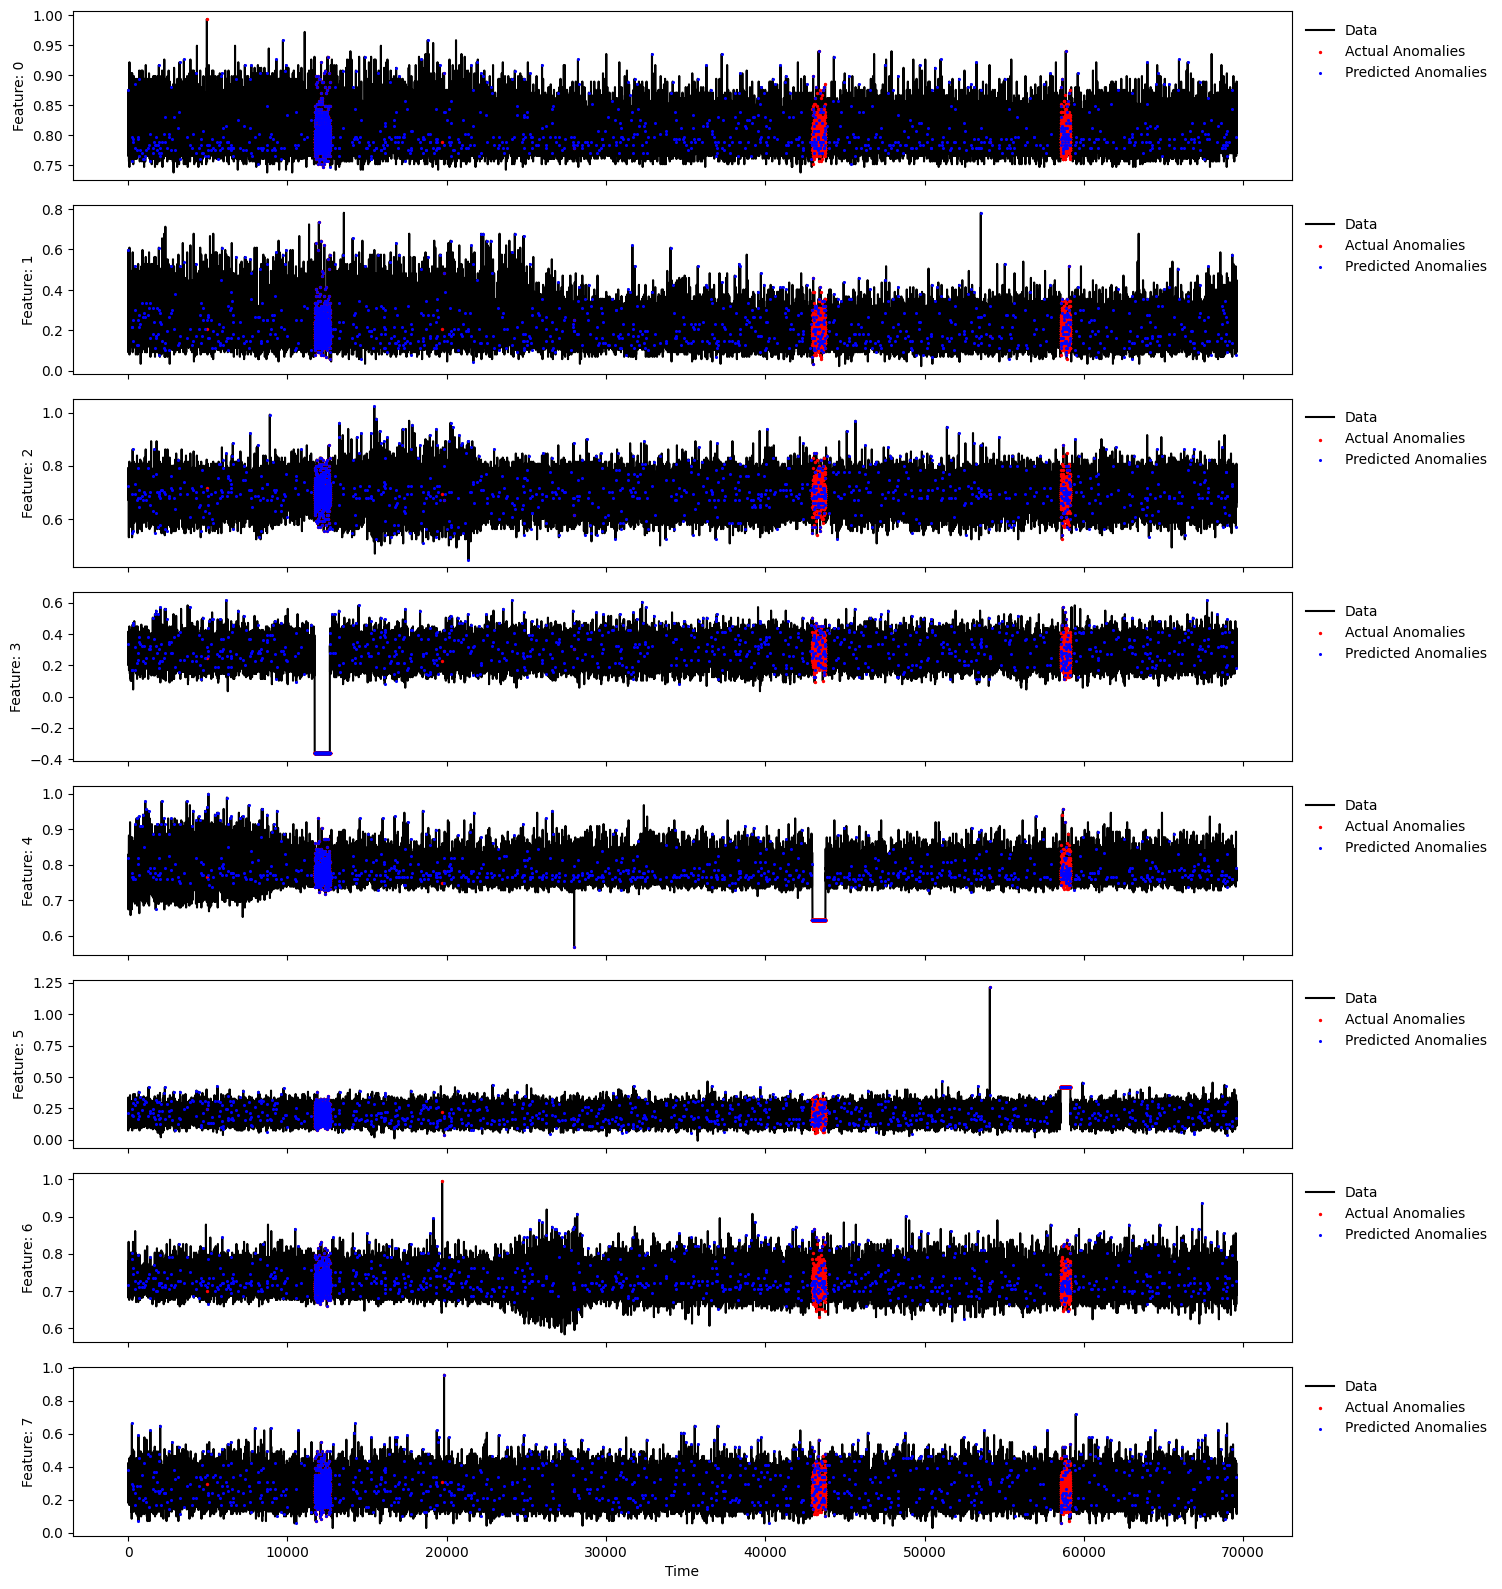

In [73]:
plot_anomaly_features(pd.DataFrame(x_test), y_pred, np.array(labels), window_size)